In [1]:
import matplotlib
from geographical_spatial_strength_extensions import *
import matplotlib.animation as animation
import math


In [2]:
sns.set()

In [3]:
def generate_rgg(n, r, size=1, pbc=False):
    G = SimpleSpatialGraph(size=[size, size])
    for _ in range(n):
        G.add_node()
        
    distances = pbc_distances(G, pbc=pbc)
    
    for i in range(G.node_count):
        for j in range(i+1, G.node_count):
            if(distances[i][j] < r*size):
                G.add_edge(i, j)
                G[i][j]['distance'] = distances[i][j]
                
    return G

def generate_neural_rgg(n, r, size=1, pbc=False, background=0.1, decay=0.5, threshold=1.0):
    '''
    generate a simple spatial rgg with conditions for neural simulation
    params:
        background: will be added randomly at uniform at +- this val to each node
        decay: will be multiplied to each nodes potential as signal decay
        threshold: firing threshold for nodes (may change this later to be picked from a distr)
    '''
    G = SimpleSpatialGraph(size=[size, size])
    G.background = background
    G.decay = decay
    G.threshold = threshold
    for _ in range(n):
        G.add_node(potential=0)
        
    distances = pbc_distances(G, pbc=pbc)
    
    for i in range(G.node_count):
        for j in range(i+1, G.node_count):
            if(distances[i][j] < r*size):
                G.add_edge(i, j, weight=np.random.uniform())
                G[i][j]['distance'] = distances[i][j]
                
    return G
    
def generate_digraph_neural_rgg(n, r, size=1, pbc=False, background=0.1, decay=0.5, threshold=1.0):
    '''
    generate a simple spatial directed rgg with conditions for neural simulation
    each node assigned fitness, node with greater fitness is the originator of edge
    params:
        background: will be added randomly at uniform at +- this val to each node
        decay: will be multiplied to each nodes potential as signal decay
        threshold: firing threshold for nodes (may change this later to be picked from a distr)
    '''
    G = SimpleSpatialDiGraph(size=[size, size])
    G.background = background
    G.decay = decay
    G.threshold = threshold
    for _ in range(n):
        G.add_node(potential=0, fitness=np.random.normal())
        
    distances = pbc_distances(G, pbc=pbc)
    
    for i in range(G.node_count):
        for j in range(i+1, G.node_count):
            if(distances[i][j] < r*size):
                if(G.node[i]['fitness'] >= G.node[j]['fitness']):
                    origin = i
                    target = j
                else:
                    origin = j
                    target = i
                G.add_edge(origin, target, weight=np.random.uniform(), distance=distances[i][j])
                
    return G
    
def simple_neural(size=1, background=0.1, decay=0.5, threshold=1.0):
    G = SimpleSpatialDiGraph(size=[size, size])
    G.background = background
    G.decay = decay
    G.threshold = threshold                
    return G

In [4]:
#spatial digraph

class SimpleSpatialDiGraph(nx.DiGraph):
    '''
    Generate a spatial graph such that every node requires an n-dimensional tuple
    coordinate
    params:
        dimension: spatial dimension of the graph, default is 2
        size: size of each dimension of the graph. Graph is assumed to start from 
            [0,0,...], default is [1,1]
         
    '''
    def __init__(self, incoming_graph_data=None, dimension=2, size=[1,1], **attr):
        super().__init__(incoming_graph_data, **attr)
        if(len(size) != dimension):
            raise Exception('Size of the graph does not match its dimension')
            
        self.dimension = dimension
        self.node_count = 0
        self.node_edges_evaluated = 0
        self.size = size
        
    def add_node(self, label=False, coordinate=None, **attr):
        '''
        Add a node optionally with a specified coordinate. If no coordinate is given,
        the node will be added with uniform random coordinates in the size of the graph
        params:
            coordinate: optional coordinate for the node
        '''
        
        if(coordinate is None):
            #no coordinate passed, generate one uniformly at random
            coordinate = []
            for i in range(self.dimension):
                coordinate.append(np.random.uniform(0, self.size[i]))
        else:
            #check that the coordinate passed matched the size of the graph
            if(type(coordinate) != list):
                raise Exception('Missing list coordinate')
            if(len(coordinate) != self.dimension):
                raise Exception('Coordinate does not have the same dimensions as the graph')
        if(not label):
            super().add_node(self.node_count, coordinate=coordinate, **attr)
        else:
            super().add_node(label, coordinate=coordinate, **attr)
        self.node_count += 1

        
class NeuralDigraph(nx.DiGraph):
    '''
    Another simple network backbone that is spatial, digraph, and has default settings for neural
    simulation functions are internal to the network
    '''
    def __init__(self, incoming_graph_data=None, dimension=2, size=[1,1], 
                             decay=0.8, background=0.1, threshold=1, reset_potential=-0.2, 
                             firing_memory_length=5, **attr):
        super().__init__(incoming_graph_data, **attr)
        if(len(size) != dimension):
            raise Exception('Size of the graph does not match its dimension')
            
        self.dimension = dimension
        self.node_count = 0
        self.node_edges_evaluated = 0
        self.size = size
        self.threshold = threshold
        self.background = background
        self.decay = decay
        self.reset_potential = reset_potential
        self.firing_memory_length = firing_memory_length
        self.age = 0
    
    
    def add_node(self, label=False, coordinate=None, potential=0, **attr):
        '''
        Add a node optionally with a specified coordinate. If no coordinate is given,
        the node will be added with uniform random coordinates in the size of the graph
        params:
            coordinate: optional coordinate for the node
        
        the node will initiate with potential, memory
        '''
        memory = 0
        if(coordinate is None):
            #no coordinate passed, generate one uniformly at random
            coordinate = []
            for i in range(self.dimension):
                coordinate.append(np.random.uniform(0, self.size[i]))
        else:
            #check that the coordinate passed matched the size of the graph
            if(type(coordinate) != list):
                raise Exception('Missing list coordinate')
            if(len(coordinate) != self.dimension):
                raise Exception('Coordinate does not have the same dimensions as the graph')
        if(not label):
            super().add_node(self.node_count, coordinate=coordinate, memory=memory, potential=potential, **attr)
        else:
            super().add_node(label, coordinate=coordinate, memory=memory, potential=potential, **attr)
        self.node_count += 1
    
    def add_edge(self, u_of_edge, v_of_edge, weight=0.5, **attr):
        super().add_edge(u_of_edge, v_of_edge, weight=weight, **attr)
        
    def continue_simulation(self, steps, granularity=1, verbose=False):
        #granularity scales every process. granularity -> 0 is asynchronous
        step_factor = 1 / granularity
        #granular_decay_rate = 1/(1 - math.e ** (math.log(g.decay) * granularity)) * g.decay
        granular_decay_rate = math.e ** (math.log(self.decay) / granularity)
        #note we shift the uniform distribution so multiply by 2 to stretch out to [-1, 1]
        granular_background_multiplier = math.e ** (-1 * math.log10(granularity)) * granularity * self.background * 2

        for i in range(steps):
            #run simulation step here
            #collect potentials
            potentials = []
            for n in range(self.node_count):
                potentials.append(self.nodes[n]['potential'])
            #decay
            for n in range(self.node_count):
                self.nodes[n]['potential'] = self.nodes[n]['potential'] * granular_decay_rate
            #add background
            #NOTE force background to not send potential negative values
            #testing exponential
            for n in range(self.node_count):
    #             new_potential = g.nodes[n]['potential'] + (np.random.uniform() - 0.5) * granular_background_multiplier
    #             if(new_potential > 0):
    #                 g.nodes[n]['potential'] = new_potential
                self.nodes[n]['potential'] += np.random.exponential(self.background / granularity)
            #fire signals if potential is greater than threshold
            #additionally, update firing memory
            #note: memory is list of length self.firing_memory_length, with index 0 being most recent time step
            for n in range(self.node_count):
                if(potentials[n] > self.threshold):
                    if(verbose):
                        print("node " + str(n) + " has potential of " + str(potentials[n]) + ". firing")
                    self.fire_signal(n)
            self.age += 1
            
    def fire_signal(self, node):
        '''
        fire a signal from the given node sending to every node it has an edge to
        can input a set reset_potential to reset nodes to after firing
        '''
        self.nodes[node]['memory'] = self.age
        for target in self[node]:
            self.nodes[target]['potential'] += self[node][target]['weight']
        if(self.reset_potential is not False):
            self.nodes[node]['potential'] = self.reset_potential
        self.learning_rules(node)
        
    def learning_rules(self, node):
        '''
        hebian learning rules
        if in-edge fired recently, increase in-edge weight
        if out-edge fired recently, decrease out-edge weight
        '''
        for origin in self.predecessors(node):
            #get most recent firing time of predecessor
            most_recent_fire = self.age - self.nodes[origin]['memory']
            if(most_recent_fire < self.firing_memory_length):
                #use a linear decay, with max weight change 0.1
                weight_change = (self.firing_memory_length - most_recent_fire - 1) / (self.firing_memory_length - 1)
                weight_change = weight_change * 0.1
                self[origin][node]['weight'] += weight_change
                #print('memory:' + str(self.nodes[origin]['memory']) + '; weight_change:'+str(weight_change)+'; mrf:'+str(most_recent_fire)+'; weight:'+str(self[0][1]))
                
        for target in self[node]:
            most_recent_fire = self.age - self.nodes[target]['memory']
            if(most_recent_fire < self.firing_memory_length):
                #also a linear decay with max weight change 0.1, but this is targets so reverse causality
                weight_change = 0.1 * (self.firing_memory_length - most_recent_fire - 1) / (1 - self.firing_memory_length)
                #note: 1 - self.firing_memory_length reverses sign
                self[node][target]['weight'] += weight_change
                

In [5]:
def visualize_digraph(G, graph_edges=True, values=False, hide_ticks=True, subplot=False,
    highlight_edges=False, highlight_recent=False, color_points=False, color_bar=False, bounds=False, pbc=False,
    edge_style=None, ss_title=False, alpha=0.5):
    '''
    Create a plot showing what a 2D spatial graph looks like, coloring by passed values and sized by degree
    params:
        G: passed in SimpleSpatialGraph
        values: values according to the labels of the nodes
        graph_edges: graph edges as well (this function takes into account periodic boundary conditions)
        highlight_edges: Optionally parameter to draw in specific edges highlighted, will 
                also highlight the latest node
        color_points: array of color labels if coloring points specifically
        bounds: given by list of lists - each row with two entries
        pbc: whether to graph as pbc
    '''
    X = []
    Y = []
    degrees = []
    scatter_values = []

    if(subplot):
        plt.subplot(subplot[0], subplot[1], subplot[2])
    else:
        plt.figure(figsize=(16, 16))
    for i in list(G.nodes):
        coordinate = G.nodes[i]['coordinate']
        X.append(coordinate[0])
        Y.append(coordinate[1])
        degrees.append(G.degree[i])
        if(values):
            scatter_values.append(values[i])
    
    if(ss_title):
        _, spatial_strength = report_spatial_strength_centrality(G, pbc=pbc, graph=False,
            ret=True, normalized=4)
        plt.title(r'S = ' + str(round(spatial_strength, 3)))
    if(graph_edges):
        head_width = G.size[0] * 0.008
        head_length = G.size[0] * 0.012
        if(pbc):
            #won't code pbc for now
                pass
        else:
            for e in G.edges:
                coordinate_i = G.nodes[e[0]]['coordinate']
                coordinate_j = G.nodes[e[1]]['coordinate']
                x = coordinate_i[0]
                y = coordinate_i[1]
                dx = coordinate_j[0] - coordinate_i[0]
                dy = coordinate_j[1] - coordinate_i[1]
                theta = math.atan2(dy, dx)
                dy -= math.sin(theta) * head_length
                dx -= math.cos(theta) * head_length
                plt.arrow(x, y, dx, dy, alpha=alpha, color='grey', head_width=head_width,
                         head_length=head_length)

    if(highlight_edges):
        pass
#         for i in highlight_edges:
#             coordinate_i = G.nodes[i[0]]['coordinate']
#             coordinate_j = G.nodes[i[1]]['coordinate']
#             x = (coordinate_i[0], coordinate_j[0])
#             y = (coordinate_i[1], coordinate_j[1])
#             plt.plot(x, y, alpha=alpha, color='red')

    if(color_points):
        plt.scatter(X, Y, c=color_points, s=degrees)
    elif(color_bar):
        plt.scatter(X, Y, c=scatter_values, s=degrees, cmap='viridis')
        plt.colorbar()
    else:
        plt.scatter(X, Y, s=degrees)
        
    if(highlight_recent):
        node = G.nodes[len(G.nodes) - 1]
        x = [node['coordinate'][0]]
        y = [node['coordinate'][1]]
        plt.scatter(x, y, c='red')
    if(bounds):
        plt.xlim([bounds[0][0], bounds[0][1]])
        plt.ylim([bounds[1][0], bounds[1][1]])
    else:
        plt.xlim([0, G.size[0]])
        plt.ylim([0, G.size[1]])

    if(hide_ticks):
        plt.xticks([])
        plt.yticks([])
        

Realize that different granularity inherently will produce different results as it decreases variance in a multiplicative fashion. There are some processes that simply behave differently with different step sizes (think optimization) so it's best to keep a consistent granularity throughout experiments.

For some reason multiplying by a factor of e for every 0.1 granularity balances out the long term distributions of the background? Maybe look into this later find a proof for why it happens

### Choices
* we will base learning rules off of the potentials of nodes connected, so only allow negative potentials after firing (not by background)
* It's hard to ensure that all of the potential adjustment occurs simultaneously: order of simulation
    * collect potentials at start of step (we will fire based on the potentials pre-decay)
    * cause potential decay
    * cause background adjustment
    * fire signals
* the reason for this ordering is so that decay doesn't influence firing
* test exponential background rate

* !the current setup has nodes being inhibitory for negative weights
* maybe makes sense to disconnect after a certain negative value

In [6]:
def continue_simulation(g, steps, granularity=1, verbose=False):
    #granularity scales every process. granularity -> 0 is asynchronous
    step_factor = 1 / granularity
    #granular_decay_rate = 1/(1 - math.e ** (math.log(g.decay) * granularity)) * g.decay
    granular_decay_rate = math.e ** (math.log(g.decay) / granularity)
    #note we shift the uniform distribution so multiply by 2 to stretch out to [-1, 1]
    granular_background_multiplier = math.e ** (-1 * math.log10(granularity)) * granularity * g.background * 2
    
    for i in range(steps):
        #run simulation step here
        #collect potentials
        potentials = []
        for n in range(g.node_count):
            potentials.append(g.nodes[n]['potential'])
        #decay
        for n in range(g.node_count):
            g.nodes[n]['potential'] = g.nodes[n]['potential'] * granular_decay_rate
        #add background
        #NOTE force background to not send potential negative values
        #testing exponential
        for n in range(g.node_count):
#             new_potential = g.nodes[n]['potential'] + (np.random.uniform() - 0.5) * granular_background_multiplier
#             if(new_potential > 0):
#                 g.nodes[n]['potential'] = new_potential
            g.nodes[n]['potential'] += np.random.exponential(g.background / granularity)
        #fire signals if potential is greater than threshold
        for n in range(g.node_count):
            if(potentials[n] > g.threshold):
                if(verbose):
                    print("node " + str(n) + " has potential of " + str(potentials[n]) + ". firing")
                fire_signal(g, n)
                #learning_rules(g, n)

    
def learning_rules(g, node):
    '''
    modify edge weights depending on learning rules
    when a node fires, have it check all edges leading to itself ie predecessors
    '''
    for origin in g.predecessors(node):
#         print(g.nodes[origin]['potential'])
        if(g.nodes[origin]['potential'] <= 0):
            #if potential is negative, increase edge weight i.e. causal
            #negative reset_potential is -0.2
            g[origin][node]['weight'] += g.nodes[origin]['potential'] * (-0.5)
        else:
            #if potential is positive, anti-causal
            #weaker multiplier since possible positive is much higher than possible negative
            g[origin][node]['weight'] += g.nodes[origin]['potential'] * (-0.2)
            

def learning_rules2(g, node):
    for origin in g.predecessors(node):
        memory = g.nodes[origin]['memory']
            


def fire_signal(g, node, reset_potential=-0.2):
    '''
    fire a signal from the given node sending to every node it has an edge to
    can input a set reset_potential to reset nodes to after firing
    '''
    for target in g[node]:
        g.nodes[target]['potential'] += g[node][target]['weight']
    if(reset_potential is not False):
        g.nodes[node]['potential'] = reset_potential
    learning_rules(g, node)

## Experiment 1
#### AIM: Test fundamental Hebian learning rule working
Goal is to synchronize 2 nodes by forcefully firing one after the other
There is a learning portion, then test to see if learning is held after

simulating learning
testing recall
{'weight': 3.4000000000000026}


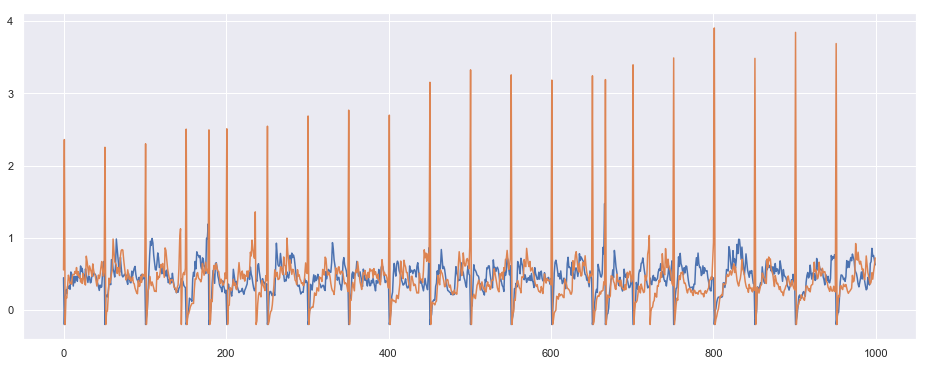

In [14]:
#experiment 1
#experiment to synchronize 2 nodes, this very basic experiment should always work
g = NeuralDigraph(decay=0.8)
g.add_node(coordinate=[0.3, 0.3], potential=0.1)
g.add_node(coordinate=[0.7, 0.7], potential=0.1)
g.add_edge(0, 1, weight=0.2)
x = []
y1 = []
y2 = []

def record(g):
    global x
    global y1
    global y2
    x.append(len(x))
    y1.append(g.node[0]['potential'])
    y2.append(g.node[1]['potential'])

print('simulating learning')
for i in range(1000):
    if(i % 50 == 0):
        g.nodes[0]['potential'] = 2
    if(i % 50 == 1):
        g.nodes[1]['potential'] = 2
        
    g.continue_simulation(1)
print('testing recall')
for i in range(1000):
    record(g)
    if(i % 50 == 0):
        g.nodes[0]['potential'] = 2
    g.continue_simulation(1)
    
print(g[0][1])
plt.figure(figsize=(16, 6))
plt.plot(x, y1, '-')
plt.plot(x, y2, '-')

simulating learning
testing recall
{'weight': -1.1999999999999997}


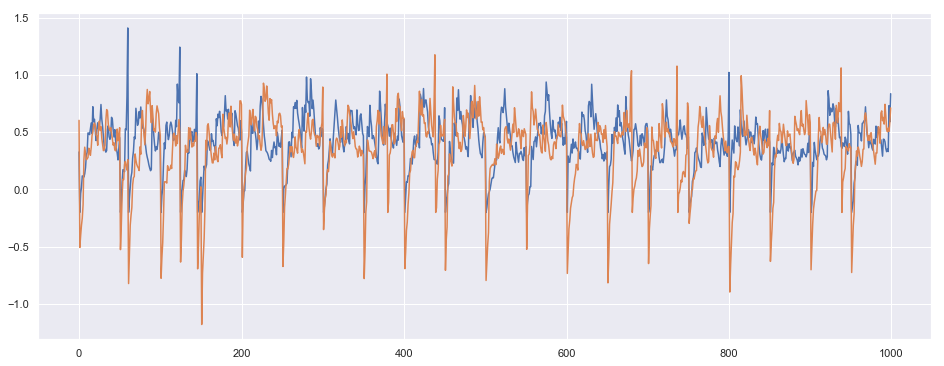

In [15]:
#experiment 1
#experiment to synchronize 2 nodes, this very basic experiment should always work
g = NeuralDigraph(decay=0.8)
g.add_node(coordinate=[0.3, 0.3], potential=0.1)
g.add_node(coordinate=[0.7, 0.7], potential=0.1)
g.add_edge(0, 1, weight=0.2)
x = []
y1 = []
y2 = []

def record(g):
    global x
    global y1
    global y2
    x.append(len(x))
    y1.append(g.node[0]['potential'])
    y2.append(g.node[1]['potential'])

print('simulating learning')
for i in range(1000):
    if(i % 50 == 1):
        g.nodes[0]['potential'] = 2
    if(i % 50 == 0):
        g.nodes[1]['potential'] = 2
        
    g.continue_simulation(1)
print('testing recall')
for i in range(1000):
    record(g)
    if(i % 50 == 0):
        g.nodes[0]['potential'] = 2
    g.continue_simulation(1)
    
print(g[0][1])
plt.figure(figsize=(16, 6))
plt.plot(x, y1, '-')
plt.plot(x, y2, '-')

## Experiment 2
#### AIM: Test decay rate (maybe background rate later) to see if it is enough to cause spontaneous firing
Not sure yet how much spontaneous firing we want to begin with, but this gives us a way to check if it is happening in the absence of external stimuli

decay of 0.3 fired 0
decay of 0.5 fired 0
decay of 0.7 fired 0
decay of 0.8 fired 6
decay of 0.9 fired 37


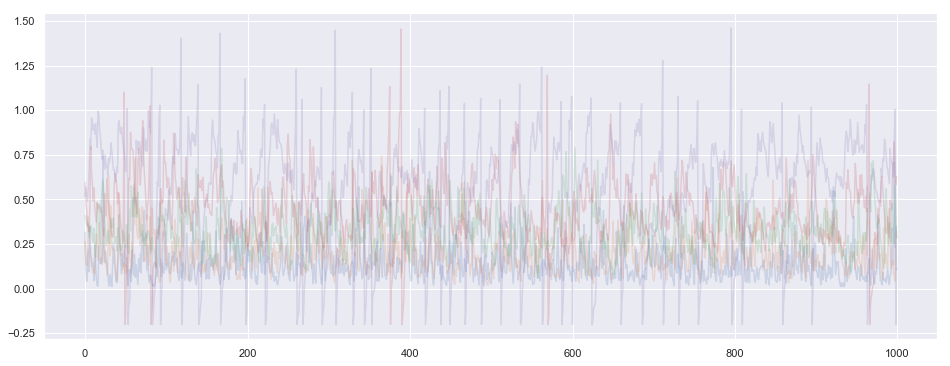

In [7]:
#experiment 2
#testing if background is enough to cause signal firing
#for now 0.8 seems reasonable
decays = [0.3, 0.5, 0.7, 0.8, 0.9]
#decays=[0.8]
potentials = {}
for decay in decays:
    g = NeuralDigraph(decay=decay)
    g.add_node(potential=0.5)
    potentials[decay] = []
    for i in range(1000):
        g.continue_simulation(1)
        potentials[decay].append(g.nodes[0]['potential'])

plt.figure(figsize=(16, 6))
for decay in decays:
    plt.plot(range(1000), potentials[decay], '-', alpha=0.2)

#count firing events:
for decay in decays:
    firings = 0
    for i in range(1000):
        if(potentials[decay][i] >= 1):
            firings += 1
    print('decay of ' + str(decay) + ' fired ' + str(firings))
    

## Experiment 3
#### Aim: Test if over time with no external stimuli edge weights tend to increase or decrease
Seems like with lower decay i.e. greater spontaneous firing, weights actually tend to decrease more
So it seems like firing on average is not causing subsequent nodes to fire? Not sure if we would want the mean weight to stay the same over time

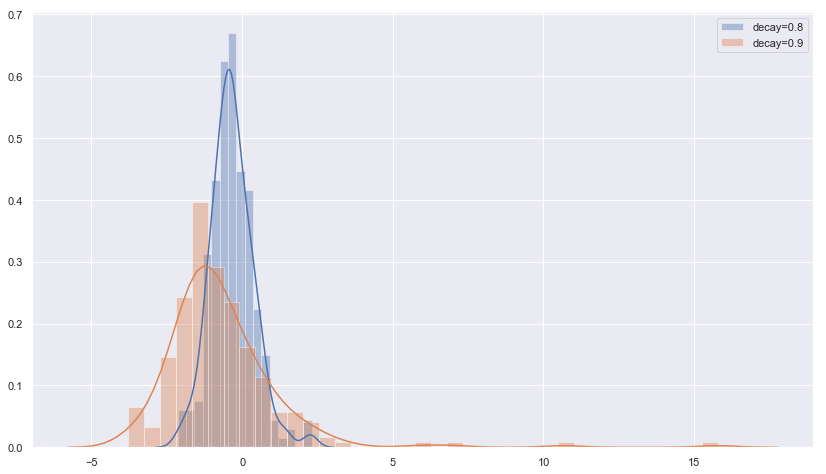

In [345]:
#experiment 3
#testing if rgg_digraph weights increase or decrease over time
plt.figure(figsize=(14, 8))
g = generate_digraph_neural_rgg(50, 0.3, decay=0.8)
continue_simulation(g, 1000)
weights = []
for e in g.edges:
    weights.append(g[e[0]][e[1]]['weight'])
sns.distplot(weights, label='decay=0.8')

#with different decay
g = generate_digraph_neural_rgg(50, 0.3, decay=0.9)
continue_simulation(g, 1000)
weights2 = []
for e in g.edges:
    weights2.append(g[e[0]][e[1]]['weight'])
sns.distplot(weights2, label='decay=0.9')
plt.legend()

## Experiment 4
#### Aim: Check under what conditions an n-cycle spontaneously generates an action potential loop

In [8]:
def generate_neural_cycle(n, decay=0.8, background=0.1):
    G = NeuralDigraph(decay=decay, background=background)
    r = 0.4
    for i in range(n):
        theta = 2 * math.pi * i / n
        x = 0.5 + r * math.cos(theta)
        y = 0.5 + r * math.sin(theta)
        G.add_node(coordinate=[x, y])
    for i in range(n):
        target = (i+1) % n
        G.add_edge(i, target, weight=0.5)
    return G

In [412]:
g = generate_neural_cycle(5, 0.9)

In [37]:
# for i in range(3, 10):
#     g = generate_neural_cycle(i, 0.8)
g = generate_neural_cycle(5, 0.8)
columns = ['timestep']
for e in g.edges():
    columns.append(str(e))
tracking = pd.DataFrame(columns=columns)
for i in range(3000):
    g.continue_simulation(1)
    append = {'timestep': g.age}
    for e in g.edges():
        append[str(e)] = g[e[0]][e[1]]['weight']
    tracking = tracking.append(append, ignore_index=True)
for e in g.edges():
    print(g[e[0]][e[1]]['weight'])

34.74999999999989
34.74999999999989
34.44999999999988
34.9249999999999
34.299999999999876


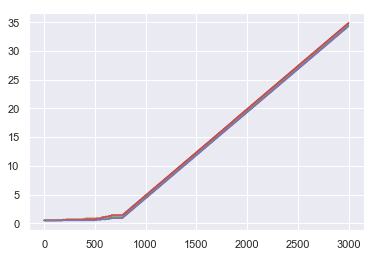

In [38]:
for e in g.edges():
    plt.plot(tracking['timestep'], tracking[str(e)])

## Experiment 5?

In [39]:
g = generate_neural_cycle(10, 0.9)
for i in range(g.node_count):
    g.add_edge(i, (i+3) % g.node_count, weight=0.5)
columns = ['timestep']
for e in g.edges():
    columns.append(str(e))
tracking = pd.DataFrame(columns=columns)
for i in range(3000):
    g.continue_simulation(1)
    append = {'timestep': g.age}
    for e in g.edges():
        append[str(e)] = g[e[0]][e[1]]['weight']
    tracking = tracking.append(append, ignore_index=True)
for e in g.edges():
    print(g[e[0]][e[1]]['weight'])

4.250000000000025
4.824999999999999
4.425000000000022
5.024999999999999
4.825000000000023
5.824999999999996
4.375000000000024
4.350000000000024
3.5750000000000224
4.275000000000024
-1.824999999999996
3.900000000000024
4.300000000000024
4.300000000000024
4.175000000000024
4.000000000000023
-2.5750000000000037
4.1500000000000234
4.250000000000024
-4.625000000000006


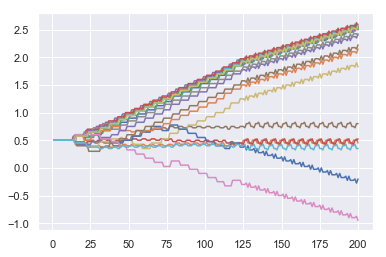

In [42]:
for e in g.edges():
    plt.plot(tracking['timestep'][0:200], tracking[str(e)][0:200])

In [41]:
def choose_points(g, coordinate, g_coords=False, ret_coords=False):
    '''
    Find a point near coordinate passed
    '''    
    coordinates = []
    if(g_coords):
        coordinates = g_coords
    else:
        for n in range(g.node_count):
            coordinates.append(g.nodes[n]['coordinate'])
    node = np.square(np.array(coordinates) - np.array(coordinate)).sum(axis=1).argmin()
    if(ret_coords):
        return node, coordinates
    else:
        return node
    
def highlight_by_coordinate(g, coordinates):
    if(type(coordinates[0]) in [int, float]):
        print('single')
        ps = [choose_points(g, coordinates)]
    else:
        ps = []
        g_coords = False
        for c in coordinates:
            p, g_coords = choose_points(g, c, g_coords, ret_coords=True)
            ps.append(p)
    
    print(ps)
    colors = []
    for i in range(g.node_count):
        if(i in ps):
            colors.append('red')
        else:
            colors.append('blue')
    return colors

single
[30]


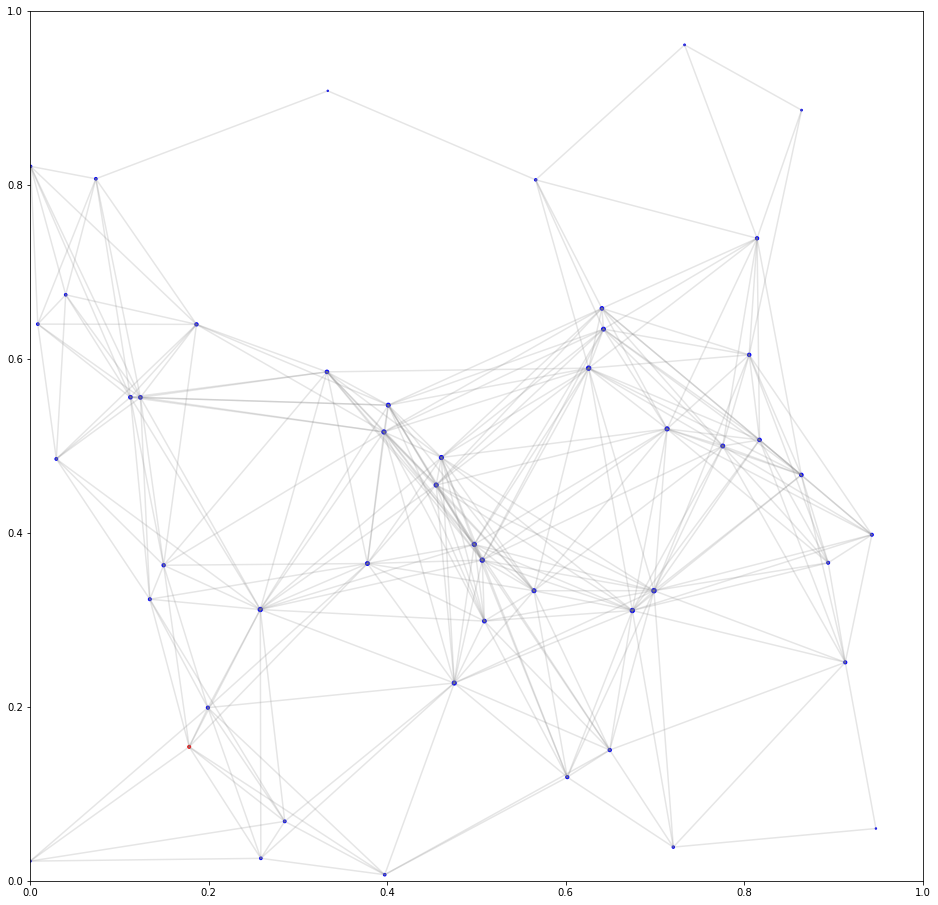

In [46]:
graph_spatial_network_plot_valued(g, color_points=colors, graph_edges=True, pbc=False)

In [96]:
100 * 0.5

50.0

In [108]:
100 * ((1 - (0.5 / 7.466)) ** 10)

49.99825478416441

In [ ]:
granular_decay_rate = 1/(1 - math.e ** (math.log(g.decay) * )) * g.decay

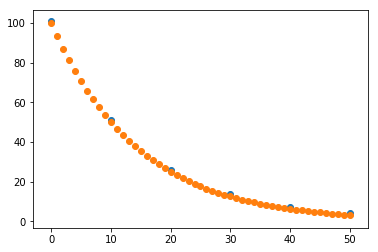

In [119]:
rate = 1/(1 - math.e ** (math.log(0.5) / 10)) * 0.5

x1 = np.array([0, 10, 20, 30, 40, 50])
y1 = 100 * (0.5 ** (x1 / 10))
x2 = np.linspace(0, 50, 51)
y2 = 100 * ((1 - (0.5 / rate)) ** x2)

plt.scatter(x1, y1 + 1)
plt.scatter(x2, y2)

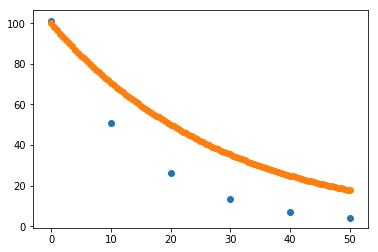

In [228]:
multiplier = 0.5
granularity = 20
rate = math.e ** (math.log(multiplier) / granularity)

x1 = np.array([0, 10, 20, 30, 40, 50])
y1 = 100 * (0.5 ** (x1 / 10))
#x2 = np.linspace(0, 50, 5*granularity + 1)
y2 = 100 * (rate ** x2)

plt.scatter(x1, y1 + 1)
plt.scatter(x2, y2)

In [123]:
granularity=0.1
1/(1 - math.e ** (math.log(g.decay) * granularity)) * g.decay

7.466363086456482

In [128]:
math.log10(1/0.1)

1.0

In [52]:
granularity = 1
(math.e ** -math.log10(granularity)) * granularity

1.0

In [49]:
granularity = 0.3
bg = (math.e ** -math.log10(granularity)) * granularity
non_granular = []
granular = []
for i in range(500):
    #trials
    ng = 0
    g = 0
    for _ in range(50):
        ng += (np.random.uniform() - 0.5) * 2
    for _ in range(int(50 / granularity)):
        g += (np.random.uniform() - 0.5) * 2 * bg
    non_granular.append(ng)
    granular.append(g)


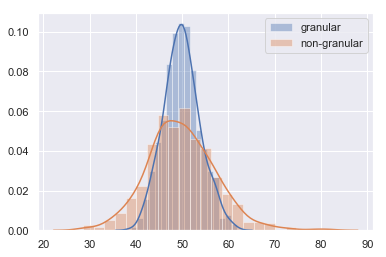

In [301]:
granularity = 0.3
bg = 0.3
# bg = 1
non_granular = []
granular = []
for i in range(500):
    #trials
    ng = 0
    g = 0
    for _ in range(50):
        ng += np.random.exponential()
    for _ in range(int(50 / granularity)):
        g += np.random.exponential(granularity)
    non_granular.append(ng)
    granular.append(g)
sns.distplot(granular, label='granular')
sns.distplot(non_granular, label='non-granular')
plt.legend()

LinAlgError: singular matrix

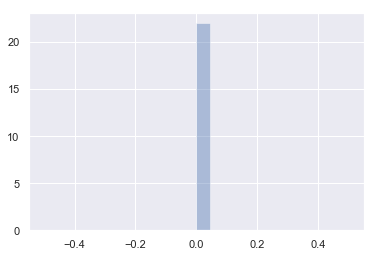

In [315]:
granularity = 0.3
bg = 0.3
# bg = 1
non_granular = []
granular = []
for i in range(500):
    #trials
    ng = np.random.exponential(0)
    g = np.random.exponential(granularity)
    non_granular.append(ng)
    granular.append(g)
# sns.distplot(granular, label='granular')
sns.distplot(non_granular, label='non-granular')
plt.legend()

In [291]:
math.e ** granularity

1.349858807576003

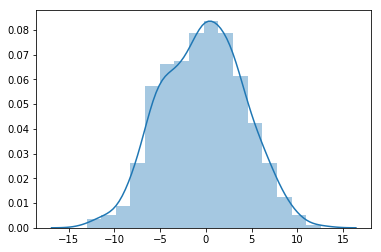

In [50]:
sns.distplot(non_granular)

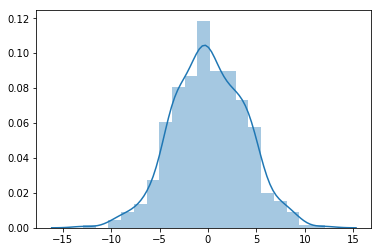

In [51]:
sns.distplot(granular)

In [46]:
(math.e ** -math.log10(granularity)) * granularity

0.03739328092797323